<a href="https://colab.research.google.com/github/Anastasiya9323/DES/blob/main/zadanie6-7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [141]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [142]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [143]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [144]:
X_train = X_train.float()
X_test = X_test.float()

In [145]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [146]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

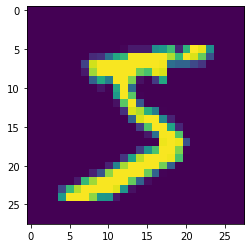

tensor(5)


In [147]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [148]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [149]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [150]:
torch.cuda.is_available()

True

In [151]:
!nvidia-smi

Sun Oct 30 19:24:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    25W /  70W |   2172MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [152]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0221,  0.0258, -0.0088,  ..., -0.0141,  0.0051, -0.0318],
         [-0.0217, -0.0136,  0.0185,  ..., -0.0012, -0.0012, -0.0017],
         [ 0.0142,  0.0089, -0.0053,  ...,  0.0311, -0.0181,  0.0020]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-3.5402e-02,  1.8178e-02, -2.1709e-02, -1.1839e-02,  4.8722e-03,
         -1.0492e-02, -1.9008e-02,  2.6994e-02, -3.4899e-02,  1.0381e-02,
         -3.5228e-02, -5.6381e-03, -2.0134e-02, -3.0264e-02, -1.3289e-02,
          2.5346e-02, -1.0797e-02,  2.1568e-03,  4.3630e-03, -2.1916e-02,
          2.2670e-02, -1.5766e-02,  3.4906e-02, -2.3063e-02, -6.8216e-03,
          2.7051e-02, -1.3991e-02,  9.7218e-03, -9.9075e-04,  1.6625e-03,
          2.3455e-02, -2

In [153]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [154]:
batch_size = 100

train_accuracy_history = []
train_loss_history = []

X_train = X_train.to(device)
y_train = y_train.to(device)

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
    
    train_preds = mnist_net.forward(X_train)
    train_loss_history.append(loss(train_preds, y_train).cpu().detach().numpy())
    
    accuracy_train = (train_preds.argmax(dim=1) == y_train).float().mean().cpu()
    train_accuracy_history.append(accuracy_train)

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).cpu().detach().numpy())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().cpu()
    test_accuracy_history.append(accuracy)
    print(epoch," ",accuracy)

0   tensor(0.9100)
1   tensor(0.9138)
2   tensor(0.9198)
3   tensor(0.9239)
4   tensor(0.9256)
5   tensor(0.9230)
6   tensor(0.9239)
7   tensor(0.9343)
8   tensor(0.9364)
9   tensor(0.9311)
10   tensor(0.9325)
11   tensor(0.9374)
12   tensor(0.9386)
13   tensor(0.9376)
14   tensor(0.9388)
15   tensor(0.9333)
16   tensor(0.9372)
17   tensor(0.9341)
18   tensor(0.9369)
19   tensor(0.9384)
20   tensor(0.9329)
21   tensor(0.9390)
22   tensor(0.9413)
23   tensor(0.9384)
24   tensor(0.9446)
25   tensor(0.9391)
26   tensor(0.9432)
27   tensor(0.9451)
28   tensor(0.9371)
29   tensor(0.9402)
30   tensor(0.9391)
31   tensor(0.9438)
32   tensor(0.9416)
33   tensor(0.9456)
34   tensor(0.9443)
35   tensor(0.9467)
36   tensor(0.9457)
37   tensor(0.9459)
38   tensor(0.9425)
39   tensor(0.9425)
40   tensor(0.9468)
41   tensor(0.9462)
42   tensor(0.9472)
43   tensor(0.9449)
44   tensor(0.9453)
45   tensor(0.9463)
46   tensor(0.9490)
47   tensor(0.9475)
48   tensor(0.9494)
49   tensor(0.9480)
50   tenso

KeyboardInterrupt: ignored

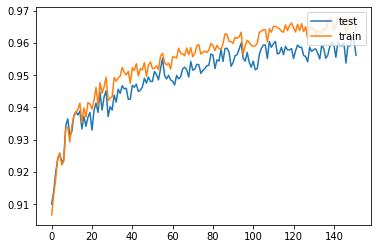

In [155]:
plt.plot(test_accuracy_history,label='test')
plt.plot(train_accuracy_history,label='train')
plt.legend(loc='upper right')

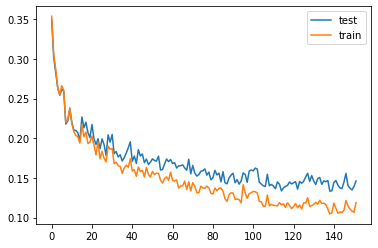

In [156]:
plt.plot(test_loss_history,label='test');
plt.plot(train_loss_history,label='train');
plt.legend(loc='upper right')
# plt.xlim([0,100])